In [1]:
# Sample API
import flowx
import simulation
import numpy
flowx.__version__

'0.1.dev'

In [2]:
# Define grid parameters
nx, ny = 10, 10
nx, ny = 70, 70
xmin, xmax = 0.0, 2.0*numpy.pi
ymin, ymax = 0.0, 2.0*numpy.pi

# Define cell-centered variable names
center_vars = ['pres', 'divv', 'asol', 'eror']
face_vars   = ['velc', 'hvar', 'asol', 'eror']

# Define boundary conditions for variable pressure and velocity [left, right, bottom, top]
bc_type_pres = {'pres': ['neumann', 'neumann', 'neumann', 'neumann']}
bc_val_pres  = {'pres': [0.0, 0.0, 0.0, 0.0]}

bc_type_u = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_u  = {'velc': [0.0, 0.0, 0.0, 0.0]}

bc_type_v = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_v  = {'velc': [0.0, 0.0, 0.0, 0.0]}

# Create the grid and data
gridc = flowx.Grid('cell-centered', center_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_pres, user_bc_val=bc_val_pres)

gridx = flowx.Grid('x-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_u, user_bc_val=bc_val_u)

gridy = flowx.Grid('y-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_v, user_bc_val=bc_val_v)

scalars = flowx.Scalars(tmax=2, dt=0.001, Re=1.0)

simulation.update_bc_val(gridx, gridy, 'velc', scalars.variable['to'])

In [3]:
simulation.get_initial(gridc, gridx, gridy, 'velc', 'pres')

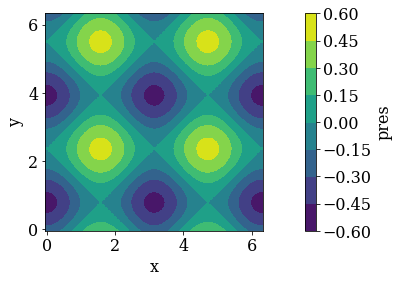

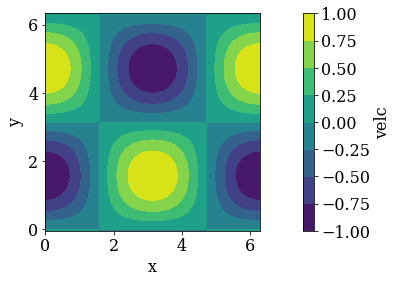

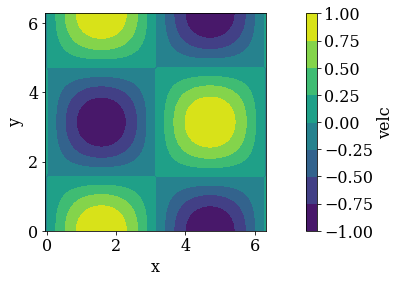

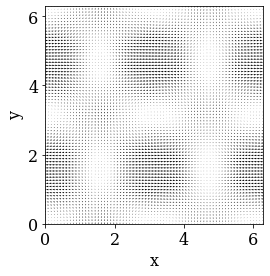

In [4]:
flowx.io.plot_contour(gridc, 'pres')
flowx.io.plot_contour(gridx, 'velc')
flowx.io.plot_contour(gridy, 'velc')
flowx.io.plot_vector(gridx, gridy, 'velc')

In [5]:
ins_vars = ['velc', 'hvar', 'divv', 'pres']

poisson_options = dict(maxiter = 2000, tol = 1e-9)
poisson_options['lu'], poisson_options['mtx'] = flowx.poisson.build_sparse(gridc, 'pres')


# Start for AB2
# Update the time-dependent boundary condition value
simulation.update_bc_val(gridx, gridy, 'velc', scalars.variable['time'])

# Predictor Step
flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'predictor')

# Divergence Step
flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'divergence')

# Solve the pressure Poisson equation 
scalars.stats['ites'], scalars.stats['res'] = flowx.poisson.solve_lu(gridc, 'pres', 'divv', 
                                                                         poisson_options)
# Corrector Step
flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'corrector')

scalars.advance()

while scalars.variable['time'] <= scalars.variable['tmax']:
    
    # Update the time-dependent boundary condition value
    simulation.update_bc_val(gridx, gridy, 'velc', scalars.variable['time'])
    
    # Predictor Step
    flowx.ins.ab2(gridc, gridx, gridy, scalars, ins_vars, 'predictor')
    
    # Divergence Step
    flowx.ins.ab2(gridc, gridx, gridy, scalars, ins_vars, 'divergence')
    
    # Solve the pressure Poisson equation 
    scalars.stats['ites'], scalars.stats['res'] = flowx.poisson.solve_lu(gridc, 'pres', 'divv', 
                                                                             poisson_options)
    # Corrector Step
    flowx.ins.ab2(gridc, gridx, gridy, scalars, ins_vars, 'corrector')
    
    # Display stats
    if scalars.variable['nstep'] % 10 == 0:
        flowx.io.display_stats(scalars)   
    
    scalars.advance()

------------ Time = 0.010000000000000002 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.2315364633151992e-12
Max, Min, U   : 0.9801986733067553, -0.9801986733067553
Max, Min, V   : 0.9801986733067553, -0.9801986733067553
Max, Min, P   : 0.4579070020229924, -0.5004692556925954
Max, Min, DIV : 1.27675647831893e-15, -1.3322676295501878e-15


------------ Time = 0.02000000000000001 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.3064543604582457e-12
Max, Min, U   : 0.9607894391523232, -0.9607894391523232
Max, Min, V   : 0.9607894391523232, -0.9607894391523232
Max, Min, P   : 0.33023312012558576, -0.5906480205960005
Max, Min, DIV : 1.3322676295501878e-15, -1.3322676295501878e-15


------------ Time = 0.03000000000000002 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.6042001716946613e-12
Max, Min, U   : 0.9417645335842487, -0.9417645335842487
Max, Min, V   : 0.9417645335842487, -0.94176453

------------ Time = 0.2700000000000002 ---------------
Number of poisson iterations    : None
Final poisson residual : 4.458112443384758e-13
Max, Min, U   : 0.5827482523739894, -0.5827482523739894
Max, Min, V   : 0.5827482523739894, -0.5827482523739894
Max, Min, P   : 0.1475672161646629, -0.19143362639327446
Max, Min, DIV : 1.1657341758564144e-15, -1.2490009027033011e-15


------------ Time = 0.2800000000000002 ---------------
Number of poisson iterations    : None
Final poisson residual : 4.965018306453356e-13
Max, Min, U   : 0.5712090638488146, -0.5712090638488146
Max, Min, V   : 0.5712090638488146, -0.5712090638488146
Max, Min, P   : 0.1108318056868191, -0.21487966425303331
Max, Min, DIV : 1.1796119636642288e-15, -1.186550857568136e-15


------------ Time = 0.2900000000000002 ---------------
Number of poisson iterations    : None
Final poisson residual : 5.192050569081186e-13
Max, Min, U   : 0.5598983665654018, -0.5598983665654018
Max, Min, V   : 0.5598983665654018, -0.5598983665654

------------ Time = 0.5300000000000004 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.628906558432944e-13
Max, Min, U   : 0.3464558103300572, -0.3464558103300572
Max, Min, V   : 0.3464558103300572, -0.3464558103300572
Max, Min, P   : 0.07039825844591746, -0.04944005513304352
Max, Min, DIV : 6.106226635438361e-16, -6.38378239159465e-16


------------ Time = 0.5400000000000004 ---------------
Number of poisson iterations    : None
Final poisson residual : 6.212023159398091e-13
Max, Min, U   : 0.3395955256449389, -0.3395955256449389
Max, Min, V   : 0.3395955256449389, -0.3395955256449389
Max, Min, P   : -0.06228679697864904, -0.17742651217720984
Max, Min, DIV : 6.245004513516506e-16, -5.759281940243e-16


------------ Time = 0.5500000000000004 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.6176008835631766e-13
Max, Min, U   : 0.33287108369807933, -0.33287108369807933
Max, Min, V   : 0.33287108369807933, -0.3328710836980

Final poisson residual : 2.009947042784414e-13
Max, Min, U   : 0.20597509820488322, -0.20597509820488322
Max, Min, V   : 0.20597509820488322, -0.20597509820488322
Max, Min, P   : 0.05775815018144438, 0.015398666302465405
Max, Min, DIV : 3.122502256758253e-16, -3.191891195797325e-16


------------ Time = 0.8000000000000006 ---------------
Number of poisson iterations    : None
Final poisson residual : 9.264479650633429e-14
Max, Min, U   : 0.20189651799465516, -0.20189651799465516
Max, Min, V   : 0.20189651799465516, -0.20189651799465516
Max, Min, P   : 0.004687850489732362, -0.03601074090612462
Max, Min, DIV : 3.885780586188048e-16, -3.191891195797325e-16


------------ Time = 0.8100000000000006 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.587193311987844e-13
Max, Min, U   : 0.19789869908361443, -0.19789869908361443
Max, Min, V   : 0.19789869908361443, -0.19789869908361443
Max, Min, P   : -0.010489355483842127, -0.04959217567854508
Max, Min, DIV : 3.

------------ Time = 1.059999999999994 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.8811216191229618e-14
Max, Min, U   : 0.12003162851145815, -0.12003162851145815
Max, Min, V   : 0.12003162851145815, -0.12003162851145815
Max, Min, P   : 0.00757085038214878, -0.006814547984061488
Max, Min, DIV : 1.6653345369377348e-16, -1.6653345369377348e-16


------------ Time = 1.069999999999993 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.42418569520965e-14
Max, Min, U   : 0.11765484302178085, -0.11765484302178085
Max, Min, V   : 0.11765484302178085, -0.11765484302178085
Max, Min, P   : 0.009924040864718918, -0.0038973050458807677
Max, Min, DIV : 1.6653345369377348e-16, -1.6653345369377348e-16


------------ Time = 1.0799999999999919 ---------------
Number of poisson iterations    : None
Final poisson residual : 4.0918718832930564e-14
Max, Min, U   : 0.1153251210380644, -0.1153251210380644
Max, Min, V   : 0.1153251210380644, -0

------------ Time = 1.3299999999999643 ---------------
Number of poisson iterations    : None
Final poisson residual : 6.912838631323704e-15
Max, Min, U   : 0.06994822174466035, -0.06994822174466035
Max, Min, V   : 0.06994822174466035, -0.06994822174466035
Max, Min, P   : 0.002906990419308442, -0.001978275637656153
Max, Min, DIV : 1.5222198501696482e-16, -1.457167719820518e-16


------------ Time = 1.3399999999999632 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.0844356713058637e-13
Max, Min, U   : 0.06856315415428296, -0.06856315415428296
Max, Min, V   : 0.06856315415428296, -0.06856315415428296
Max, Min, P   : 0.023820317521097208, 0.019126604268051236
Max, Min, DIV : 1.5265566588595902e-16, -1.457167719820518e-16


------------ Time = 1.3499999999999621 ---------------
Number of poisson iterations    : None
Final poisson residual : 6.537165353815429e-14
Max, Min, U   : 0.06720551273975486, -0.06720551273975486
Max, Min, V   : 0.06720551273975486, 

------------ Time = 1.5899999999999357 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.1805188531106034e-14
Max, Min, U   : 0.04158565512117852, -0.04158565512117852
Max, Min, V   : 0.04158565512117852, -0.04158565512117852
Max, Min, P   : -0.0014120409425452986, -0.003139784148464788
Max, Min, DIV : 7.719519468096792e-17, -7.632783294297951e-17


------------ Time = 1.5999999999999346 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.7703395381602317e-14
Max, Min, U   : 0.04076220397837155, -0.04076220397837155
Max, Min, V   : 0.04076220397837155, -0.04076220397837155
Max, Min, P   : -0.0045490914096168724, -0.006209176226611978
Max, Min, DIV : 7.28583859910259e-17, -7.632783294297951e-17


------------ Time = 1.6099999999999335 ---------------
Number of poisson iterations    : None
Final poisson residual : 6.986408617617478e-14
Max, Min, U   : 0.039955058260659225, -0.039955058260659225
Max, Min, V   : 0.03995505826065

------------ Time = 1.849999999999907 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.0410459900809312e-14
Max, Min, U   : 0.02472352647034399, -0.02472352647034399
Max, Min, V   : 0.02472352647034399, -0.02472352647034399
Max, Min, P   : -0.0036974039735536116, -0.004309624809385687
Max, Min, DIV : 3.9898639947466563e-17, -3.9898639947466563e-17


------------ Time = 1.859999999999906 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.663145017091328e-14
Max, Min, U   : 0.024233967845695675, -0.024233967845695675
Max, Min, V   : 0.024233967845695675, -0.024233967845695675
Max, Min, P   : -0.0031546489309070263, -0.0037430200206465753
Max, Min, DIV : 3.9898639947466563e-17, -4.163336342344337e-17


------------ Time = 1.8699999999999048 ---------------
Number of poisson iterations    : None
Final poisson residual : 4.590749208440195e-14
Max, Min, U   : 0.02375410313130952, -0.02375410313130952
Max, Min, V   : 0.0237541031

In [6]:
simulation.get_analytical(gridc, gridx, gridy, 'asol', scalars.variable['time'])

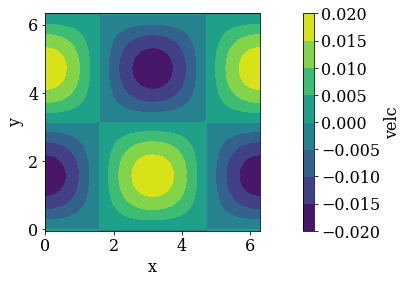

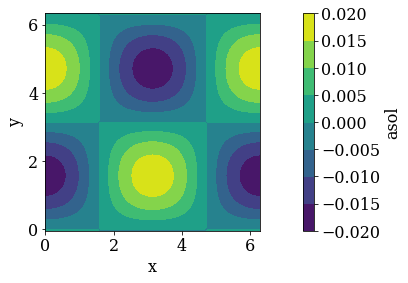

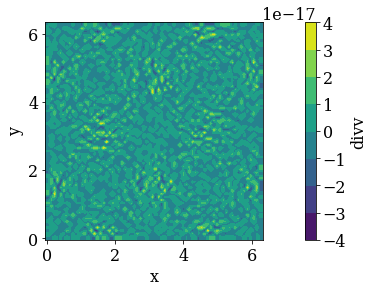

In [7]:
flowx.io.plot_contour(gridx, 'velc')
flowx.io.plot_contour(gridx, 'asol')
flowx.io.plot_contour(gridc, 'divv')

In [8]:
gridx.get_error('eror','velc','asol')
gridy.get_error('eror','velc','asol')

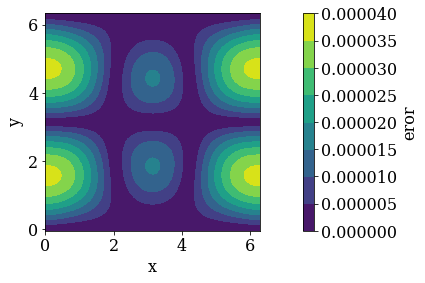

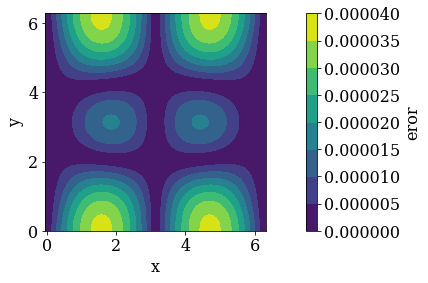

In [9]:
flowx.io.plot_contour(gridx, 'eror')
flowx.io.plot_contour(gridy, 'eror')

In [10]:
# print( numpy.mean( gridx.get_l2_norm( 'eror' ) ) )
# # [ 1.4260690583153957e-06, 1.7205807679220677e-06, 1.8800437955070747e-06, 1.9611326796676977e-06 ]
# print( numpy.mean( gridy.get_l2_norm( 'eror' ) ) )
# # [ 1.426069058315395e-06, 1.7205807679220639e-06, 1.880043795507073e-06, 1.961132679667697e-06 ]

In [11]:
print( numpy.mean( gridx.get_l2_norm( 'eror' ) ) )
# [ 0.00010312780334735345, 1.3808333846081412e-05, 1.4260690583153957e-06, 2.1489279494331196e-07 ]
print( numpy.mean( gridy.get_l2_norm( 'eror' ) ) )
# [ 0.00010312780334735339, 1.3808333846081412e-05, 1.426069058315395e-06, 2.1489279494331143e-07 ]

2.1489279494331196e-07
2.1489279494331143e-07
